In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Titanic Data Set

We are going to take a look at the popular titanic data set. I would like to try various methods to clean the data and deal with our missing values,and fit two common models of random forest and logistic regression. The following lines will read our data and give us some basic information.

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We have taken a look at the given data, we see that it is going to be a binary response variable for survivorship so some sort of categorical model is appropriate. As stated earlier we will be looking at the random forest and logistic regression models. 

Before we get into that, some data cleaning must be performed. We see that the age, cabin and embarked features are all missing values in the training data set, and in the test data set we have missing values for age, fare and cabin.

Additionally, the features for name, cabin, and ticket seem to be quite difficult to value from my current perspective. If we were to value these variables in our final model can we find some sort of justification. We should take a closer look at these features and see if anything becomes more apparent.

Lets do some data exploration.

# Missing value treatment

## Continuous features (Fare/age)

<AxesSubplot:title={'center':'Age'}, xlabel='[Survived]'>

<Figure size 432x288 with 0 Axes>

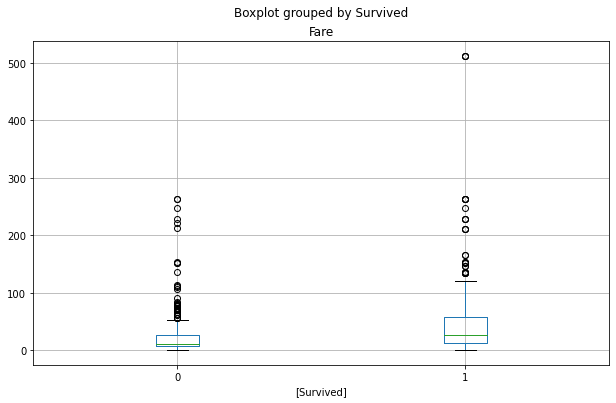

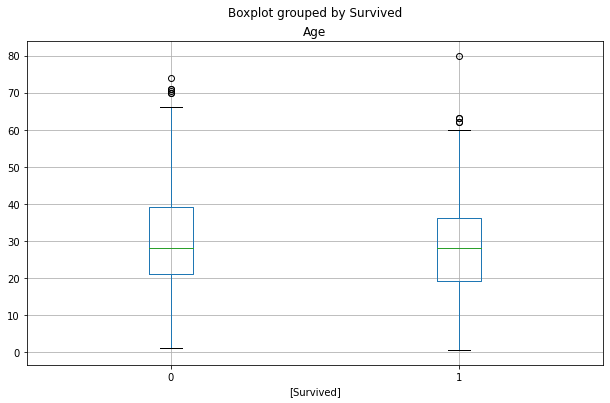

In [5]:
import matplotlib.pyplot as plt

#take a look at our continuous variables

plt.figure()

train_data.boxplot(column = ['Fare'], by = ['Survived'], figsize = (10,6))

train_data.boxplot(column = [ 'Age'], by = ['Survived'], figsize = (10,6))

In the train data we have some fares that are over 500, quite a bit higher than the other fares. Lets take a look at those values. Additionally, we see that the ages look quite nice with no real differences. I will take a closer look at the 80 year old who survived though.

In [6]:
train_data[train_data['Fare'] > 500]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


In [7]:
train_data[train_data['Age']> 78]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0,A23,S


A few fares over 500, check to see if there are any in the test data as well. I read a tiny bit about Mr. Algernon Barkworth and it seems he's just a lucky man, no additional insight there that I could tell. I have checked the test data as well, and we have another high value there as well.

In [8]:
test_data[test_data['Fare']> 500]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
343,1235,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C


I would like to deal with the missing values in age and fare. Lets take a quick look at a graph. Recall that all of the excessive fares are from first class.

<AxesSubplot:title={'center':'Fare'}, xlabel='[Pclass]'>

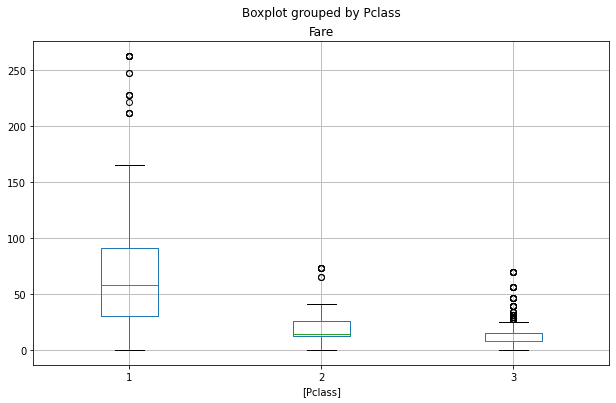

In [9]:
train_data[train_data['Fare'] < 500].boxplot(column = ['Fare'], by = ['Pclass'], figsize = (10,6))

The fare values seem to be very different for first class vs second or third class. Perhaps there's an argument for second and third class having different means as well. I am a little curious so lets take a look.

In [10]:
from scipy import stats

test1 = train_data["Fare"][train_data["Pclass"] == 2]

test2 = train_data["Fare"][train_data["Pclass"] == 3]

stats.ttest_ind(test1,test2, equal_var = False)

print(test1.mean())
print(test2.mean())


20.66218315217391
13.675550101832997


So lets replace some of these values. I will replace any missing fares with the mean from the respective class for that individual. For example, if the fare is missing but I know the passenger was in second class, I would replace it with 20.66.

In [11]:
train_data["Fare"].replace({ 512.3292 : train_data["Fare"][train_data["Pclass"]==1].mean()}, inplace=True)
test_data["Fare"].replace({ 512.3292 : train_data["Fare"][train_data["Pclass"]==1].mean()}, inplace=True)

In [12]:
test_data["Fare"].replace({ np.nan : train_data["Fare"][train_data["Pclass"]==3].mean()}, inplace=True)

And we can fill in the missing ages as the average. But again, maybe we can check if there is a difference between the ages based off of the Pclass feature.

### Mapping the Title feature

I will also use a strategy from [Peter Biggle](https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9) outlined on his blog post to deal with the name categories. 

A basic check to see differences by ticket class, then we will split the prefixes of the names into its own feature.

38.233440860215055
29.87763005780347
25.14061971830986


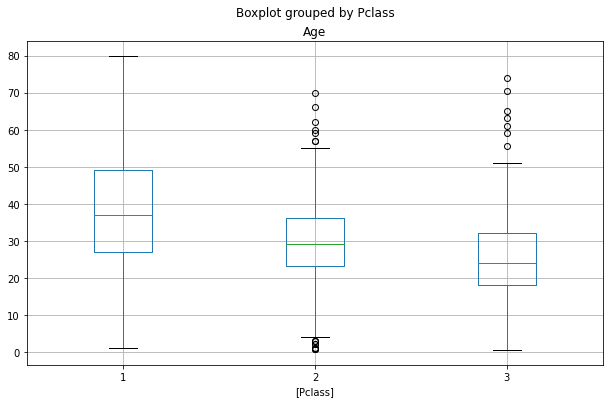

In [13]:
train_data.boxplot(column = ['Age'], by = ['Pclass'], figsize = (10,6))

for i in range(3):
    print(train_data["Age"][train_data["Pclass"] == (i+1)].mean())

In [14]:
train_data['Title'] = train_data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
train_data.Title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Jonkheer          1
Mme               1
Sir               1
Don               1
Capt              1
Ms                1
Lady              1
the Countess      1
Name: Title, dtype: int64

In [15]:
test_data['Title'] = test_data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
test_data.Title.value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Ms          1
Dona        1
Dr          1
Name: Title, dtype: int64

In [16]:
#And now a map for normalized names.

normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royal",
    "Don":        "Royal",
    "Sir" :       "Royal",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royal",
    "Dona":       "Royal",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royal"
}

# map the normalized titles to the current titles for train and test data.
train_data.Title = train_data.Title.map(normalized_titles)
test_data.Title = test_data.Title.map(normalized_titles)

Okay we now have titles in order to pull some information from the name feature. We can use the titles and the Pclass feature to better input an age for each missing age.

In [17]:
# group by Sex, Pclass, and Title 
grouped = train_data.groupby(['Sex','Pclass', 'Title'])  # view the median Age by the grouped features 
grouped.Age.median()

Sex     Pclass  Title  
female  1       Miss       30.0
                Mrs        40.0
                Officer    49.0
                Royal      40.5
        2       Miss       24.0
                Mrs        31.5
        3       Miss       18.0
                Mrs        31.0
male    1       Master      4.0
                Mr         40.0
                Officer    51.0
                Royal      40.0
        2       Master      1.0
                Mr         31.0
                Officer    46.5
        3       Master      4.0
                Mr         26.0
Name: Age, dtype: float64

In [18]:
#fill the missing values with the information from the training data

test_data.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))
train_data.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))

In [19]:
#check the missing values again.
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

In [20]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Title            0
dtype: int64

Continuous Features are accounted for so lets take a look at categorical features next.

## Categorical Features

We will need to map most of these to dummy variables, we also have lots of missing values for cabin which need to be addressed. Two values of the embarked feature are missing in the training set which will be mapped to the mode of the feature. I would like to keep the cabin feature as they may indicate relative position on the titanic (How close to life boats) and I would like to remove the ticket variable as I do not think there is anything of value there. 


In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#initialize label endoce as first step.
le = LabelEncoder()

train_data["Sex"] = le.fit_transform(train_data["Sex"].values)
test_data["Sex"] = le.fit_transform(test_data["Sex"].values)

#This will give us 0, 1 for this category.

In [22]:
#Drop ticket
train_data = train_data.drop(['Ticket'], axis=1)
test_data = test_data.drop(['Ticket'], axis=1)

In [23]:
#Fill cabin with U For unknown, then replace the variable with just the leading letter for rough location.\.

train_data.Cabin = train_data.Cabin.fillna('U')
test_data.Cabin = test_data.Cabin.fillna('U')


In [24]:
#We map all cabin values to just the leading letter to group them.
for i in range(len(train_data.Cabin)):
    train_data.Cabin[i] = train_data.Cabin[i][0]


for j in range(len(test_data.Cabin)):
    test_data.Cabin[j] = test_data.Cabin[j][0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [25]:
#Take a look at the embarked feature.
train_data["Embarked"].value_counts()

train_data["Cabin"].replace({ "T" : 'U'}, inplace=True)

In [26]:
#S is the mode of the feature, so we will replace the two missing values with these.
train_data["Embarked"].replace({ np.nan : "S"}, inplace=True)

#take a peek at the missing values left.
train_data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
Title          0
dtype: int64

In [27]:
test_data.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
Title          0
dtype: int64

We have delt with all missing values. We will now use the label encoder to deal with cabin and embarked so we can use the onehotencoder. If we do not do this, our model may confused the variables with ordinal variables.

In [28]:
#I believe with pd get dummies this is not needed.
#train_data["Cabin"] = le.fit_transform(train_data["Cabin"].values)
#test_data["Cabin"] = le.fit_transform(test_data["Cabin"].values)

#train_data["Embarked"] = le.fit_transform(train_data["Embarked"].values)
#test_data["Embarked"] = le.fit_transform(test_data["Embarked"].values)

In [29]:
#here we can see we have encoded the labels to numeric values.
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,U,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,C,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,U,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,C,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,U,S,Mr


# Modeling
Most problems seem to have been dealt with. Lets start feeding our dataset into some models.

In [30]:
#random forest
from sklearn.ensemble import RandomForestClassifier

y_train = train_data["Survived"]


features = ["Pclass", "Sex", "Age", "Parch","Fare", "SibSp","Cabin","Title", "Embarked"]

#Create dummy variables and drop one of them in order to reduce colinearity. (i.e. If we have a category with 3 possibilities, we only need two indicators, 1st and 2nd.
# The absence of both will indicate the 3rd.)
#This will "Finalize" our training set for the model.
X_train = pd.get_dummies(train_data[features], drop_first = True)

#We will do the same for the test set.
X_test = pd.get_dummies(test_data[features], drop_first = True)

#I would like to look at Feature importance for model selection

feat_labels = X_train.columns[:]

forest = RandomForestClassifier(n_estimators = 500, random_state = 1)


 1) Fare                           0.222739
 2) Age                            0.213219
 3) Title_Mr                       0.124203
 4) Sex                            0.116385
 5) Pclass                         0.065276
 6) SibSp                          0.053681
 7) Title_Mrs                      0.034173
 8) Cabin_U                        0.032992
 9) Parch                          0.032193
10) Title_Miss                     0.032051
11) Embarked_S                     0.019992
12) Embarked_Q                     0.010988
13) Cabin_E                        0.009200
14) Title_Officer                  0.008207
15) Cabin_C                        0.006835
16) Cabin_B                        0.006663
17) Cabin_D                        0.006495
18) Cabin_F                        0.002118
19) Cabin_G                        0.001486
20) Title_Royal                    0.001102


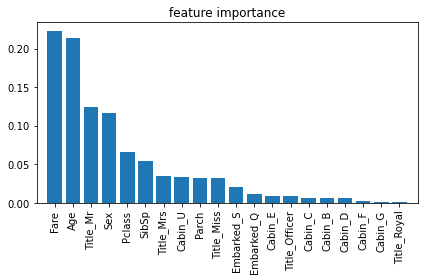

In [31]:
#This should be a good look at feature importance.
forest.fit(X_train, y_train)

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range (X_train.shape[1]):
    print("{:2}) {:30s} {:f}".format(f+1, feat_labels[indices[f]],
                            importances[indices[f]]))

import matplotlib.pyplot as plt
plt.title('feature importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices], 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

Feature importance is scaled to sum to one. For the random forest model I will simply include everything. Lets see how it fits.



In [32]:
#Finally we will fit and predict.
model = RandomForestClassifier(n_estimators=500, max_depth=5)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

#and get the output
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## Logistic Regression

Lets work on a logistic regression model and use some new methods I have recently been studying. We will use the train-test-split function from sklearn so we can test our change in-house. This should allow us to rapidly assess changes we've made to our model.

The idea here is that we will use these sets to get a closer look at the bias and variance of our model and see if we can't improve it before submitting. We have luckily done a large portion of the data manipulation earlier, so we should be able to make quick progress.

Finally, after taking a look at the bias and variance, we will decide on whether to include polynomial or interaction terms.

In [33]:
from sklearn.model_selection import train_test_split

X_train2, X_cv, y_train2, y_cv = train_test_split(X_train, y_train, test_size = 0.3, random_state = 0, stratify = y_train) 

X_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 231 to 80
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         623 non-null    int64  
 1   Sex            623 non-null    int64  
 2   Age            623 non-null    float64
 3   Parch          623 non-null    int64  
 4   Fare           623 non-null    float64
 5   SibSp          623 non-null    int64  
 6   Cabin_B        623 non-null    uint8  
 7   Cabin_C        623 non-null    uint8  
 8   Cabin_D        623 non-null    uint8  
 9   Cabin_E        623 non-null    uint8  
 10  Cabin_F        623 non-null    uint8  
 11  Cabin_G        623 non-null    uint8  
 12  Cabin_U        623 non-null    uint8  
 13  Title_Miss     623 non-null    uint8  
 14  Title_Mr       623 non-null    uint8  
 15  Title_Mrs      623 non-null    uint8  
 16  Title_Officer  623 non-null    uint8  
 17  Title_Royal    623 non-null    uint8  
 18  Embarked_

So we've split the data, lets do some standardization on the features then throw it at the LR model.

In [34]:
#First standardization
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train2)
X_cv_std = stdsc.fit_transform(X_cv)


In [35]:
#Let logistic regression with L2 regularization have a go, Start with the regularzation parameter C = 1.
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = "l2", C = 3, max_iter = 500)

lr.fit(X_train_std, y_train2)


LogisticRegression(C=3, max_iter=500)

In [36]:
print("LR Training accuracy:", lr.score(X_train_std, y_train2))
print("LR Cross Validation Accuracy", lr.score(X_cv_std, y_cv))

#For fun, lets see how the RF did in-house.
print("RF Training accuracy:", model.score(X_train2, y_train2))
print("RF Cross Validation Accuracy", model.score(X_cv, y_cv))


LR Training accuracy: 0.841091492776886
LR Cross Validation Accuracy 0.832089552238806
RF Training accuracy: 0.8362760834670947
RF Cross Validation Accuracy 0.8619402985074627


It seems like we have decent performance from the LR model, but as of now it is still out-performed by the random forest. Lets adjust C and see if we can't get a better fit, then we can try adding interaction and/or polynomial features.

In [37]:
def validationCurve(X, y, Xcv, ycv):
    """
    Generate the train and validation errors needed to plot a validation
    curve that we can use to select C.
    
    Parameters
    ----------
    X : array_like
        The training dataset. Matrix with shape (m x n) where m is the 
        total number of training examples, and n is the number of features 
        including any polynomial features.
    
    y : array_like
        The functions values at each training datapoint. A vector of
        shape (m, ).
    
    Xval : array_like
        The validation dataset. Matrix with shape (m_val x n) where m is the 
        total number of validation examples, and n is the number of features 
        including any polynomial features.
    
    yval : array_like
        The functions values at each validation datapoint. A vector of
        shape (m_val, ).
    
    Returns
    -------
    lambda_vec : list
        The values of the regularization parameters which were used in 
        cross validation.
    
    error_train : list
        The training error computed at each value for the regularization
        parameter.
    
    error_val : list
        The validation error computed at each value for the regularization
        parameter.

    """
    # Selected values of C
    C = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    #initialize the array for the errors.
    error_train = np.zeros(len(C))
    error_cv = np.zeros(len(C))

    #=====================================
    #This will take an LR model for each value of C in our array.
    
    for i in range(len(C)):
        c = C[i]
        lr = LogisticRegression(penalty = "l2", C = c, max_iter = 500)
        lr.fit(X, y)
        error_train[i] = 1 - lr.score(X, y)
        error_cv[i] = 1 - lr.score(Xcv, ycv)
    # ============================================================
    return C, error_train, error_cv

lambda		Train Error	Validation Error
 0.001000	0.279294	0.276119
 0.003000	0.186196	0.186567
 0.010000	0.184591	0.182836
 0.030000	0.176565	0.182836
 0.100000	0.162119	0.175373
 0.300000	0.157303	0.175373
 1.000000	0.158909	0.171642
 3.000000	0.158909	0.167910
 10.000000	0.160514	0.167910


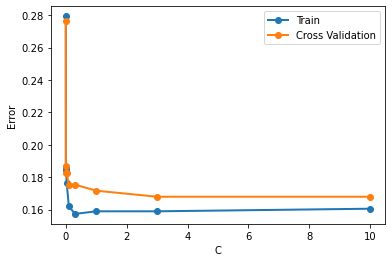

In [38]:
#Now lets see if we can't plot it.
C, error_train, error_cv = validationCurve(X_train_std, y_train2, X_cv_std, y_cv)

plt.plot(C, error_train, '-o', C, error_cv, '-o', lw=2)
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('C')
plt.ylabel('Error')

print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(C)):
    print(' %f\t%f\t%f' % (C[i], error_train[i], error_cv[i])) 

Alright, we see that we can seemingly increase our accuracy by using C = 3.0 vs C = 1.0. By a whopping ~0.004. Lets throw a bunch of variables at this and try again.

We will include all polynomial terms of two degrees. That is xi^2 and xi\*xj for all i != j. This will include all interaction terms for the explanatory variables. 

In [39]:
#Get the polynomial features from the data set. 2 degrees.
from sklearn.preprocessing import PolynomialFeatures
#poly = PolynomialFeatures(degree = 2, interaction_only = True)
poly = PolynomialFeatures(degree = 2)

#Fit the features on the training data before standardization, then we'll standardize after.
X_train_poly = poly.fit_transform(X_train2)
X_cv_poly = poly.fit_transform(X_cv)

#And standardize.
X_train_stdpoly = stdsc.fit_transform(X_train_poly)
X_cv_stdpoly = stdsc.fit_transform(X_cv_poly)

#take a peek. #We see 231 explanatory features now.
X_train_poly.shape[1]

231

Lets feed this back into our ValidationCurve function and see if we can find a good value for C.

lambda		Train Error	Validation Error
 0.001000	0.181380	0.190299
 0.003000	0.168539	0.194030
 0.010000	0.152488	0.182836
 0.030000	0.144462	0.171642
 0.100000	0.134831	0.164179
 0.300000	0.130016	0.164179
 1.000000	0.131621	0.164179
 3.000000	0.123596	0.160448
 10.000000	0.115570	0.175373


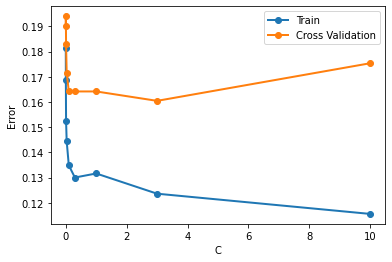

In [40]:
C, error_train, error_cv = validationCurve(X_train_stdpoly, y_train2, X_cv_stdpoly, y_cv)

plt.plot(C, error_train, '-o', C, error_cv, '-o', lw=2)
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('C')
plt.ylabel('Error')

print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(C)):
    print(' %f\t%f\t%f' % (C[i], error_train[i], error_cv[i])) 

We've scraped together a tiny bit more accuracy, but we can see our model is becoming overfit. C = 3 seems to work okay. So lets make this our final LR model and give it a submission.



In [41]:
#Apply the standardization and polynomial features to the entire train data, instead of our split.
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

#And standardize.
X_train_stdpoly = stdsc.fit_transform(X_train_poly)
X_test_stdpoly = stdsc.fit_transform(X_test_poly)

#And a standardized, non-poly.
X_test_std = stdsc.fit_transform(X_test)
X_train1_std = stdsc.fit_transform(X_train)


In [42]:
#Feed it into our Logistic Regression model and record predictions.
model_LR = LogisticRegression(penalty = "l2", C = 3, max_iter = 500)
model_LR.fit(X_train_stdpoly, y_train)
predictions = model_LR.predict(X_test_stdpoly)

#and get the output
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('LRmodel overfit.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [43]:
#Lets also do a non-overfit model.
model_LR2 = LogisticRegression(penalty = "l2", C = 3, max_iter = 500)
model_LR2.fit(X_train1_std, y_train)
predictions = model_LR2.predict(X_test_std)

#and get the output
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('LRmodel-standard.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## Other models

Lets take a look at other categorical models. SVM, KNN, and a neural network will be the models of interest.

I will also implement sequential backwards selection for feature selection on the KNN classifier.

## KNN

K-nearest Neighbors is a non-parametric, lazy learning algorithm. It is particularly suspect to overfitting. We will run it through feature selection to attempt to avoid that. First, lets get a baseline on our training set without feature selection.

In [44]:
# Basic KNN

#from sklearn.feature_selection import SequentialFeatureSelector
#sfs = SequentialFeatureSelector(knn, n_features_to_select=3)

from sklearn.neighbors import KNeighborsClassifier



knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_std, y_train2)
print("Training Accuracy KNN", knn.score(X_train_std, y_train2))
print("Cross Validation accuracy:", knn.score(X_cv_std, y_cv))


Training Accuracy KNN 0.8635634028892456
Cross Validation accuracy: 0.8022388059701493


## KNN with SBS

Sequential Backwards feature selection, courtesy of Python Machine Learning, 2nd edition. Backwards selection tends to overfit in comparison to forward selection, which seems to perform slightly better. 

SKlearn also has backwards selection, but this implementation is nice for visualization, as it stores the errors as it does the selection. We can then plot them and decide on a good number of features.

In [45]:
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test =             train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

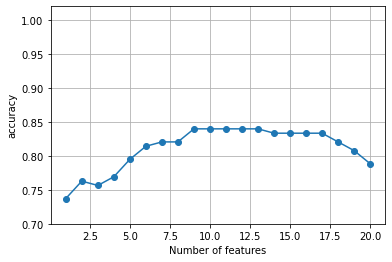

In [46]:
#Lets run the model through SBS
sbs = SBS(knn, k_features= 1)
sbs.fit(X_train_std, y_train2)

k_feat = [len(k) for k in sbs.subsets_]



plt.plot(k_feat, sbs.scores_, marker ='o')
plt.ylim([0.7, 1.02])
plt.ylabel("accuracy")
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [47]:
#We see that using 9 features seems to yield the best results with the fewest number of features. Lets see how we do.
#9 features is the 12th iteration of our SBS so lets pull the features.
k9 = list(sbs.subsets_[11])

print(X_train.columns[k9])

Index(['Pclass', 'Sex', 'Age', 'Fare', 'SibSp', 'Cabin_E', 'Cabin_U',
       'Title_Mr', 'Embarked_S'],
      dtype='object')


In [48]:
#Lets fit the model to these 9 features and see how we compare.

knn2 =  KNeighborsClassifier(n_neighbors = 5)
knn2.fit(X_train_std[:,k9], y_train2)
print("Training accuracy KNN w/ Feature Selection:", knn2.score(X_train_std[:,k9], y_train2))
print("Cross Validation accuracy w/ Feature Selection:", knn2.score(X_cv_std[:,k9], y_cv))

print("Training Accuracy KNN", knn.score(X_train_std, y_train2))
print("Cross Validation accuracy:", knn.score(X_cv_std, y_cv))

Training accuracy KNN w/ Feature Selection: 0.869983948635634
Cross Validation accuracy w/ Feature Selection: 0.832089552238806
Training Accuracy KNN 0.8635634028892456
Cross Validation accuracy: 0.8022388059701493


## KNN results

By restricting the number of features we see a marked improvement on the accuracy of our model, from 80% to 83% On the cross validation data. This seems to be a very nice result.

## SVM

This is perhaps the model I am least familiar with. I am going to calculate two SVM models, one with a linear kernel and one with a gaussian kernel (RBF). 

In [49]:
#Both models.
from sklearn.svm import SVC
svm = SVC(kernel = "linear", C = 1.0, random_state = 1)
svm.fit(X_train_std, y_train2)

svm2 = SVC(kernel = "rbf", gamma = 0.2, C = 1.0, random_state = 1)
svm2.fit(X_train_std, y_train2)

print("Training accuracy SVM w/ linear kernel:", svm.score(X_train_std, y_train2))
print("Cross Validation accuracy w/ linear kernel:", svm.score(X_cv_std, y_cv))

print("Training Accuracy SVM w/ gaussian kernel", svm2.score(X_train_std, y_train2))
print("Cross Validation accuracy w/ gaussian kernel:", svm2.score(X_cv_std, y_cv))


Training accuracy SVM w/ linear kernel: 0.8314606741573034
Cross Validation accuracy w/ linear kernel: 0.8171641791044776
Training Accuracy SVM w/ gaussian kernel 0.8796147672552167
Cross Validation accuracy w/ gaussian kernel: 0.8283582089552238


## SVM results
We see the gaussian kernel performed marginally better on the cross validation set. There may be more room for improvment by modifying c and/or gamma to affect the fit.

Both of these models seem to work well but are being slightly out-performed by previous models.

## Neural Network

Here's a neural network implimented via sklearn using backprop. Lets see how it does.

In [50]:
from sklearn.neural_network import MLPClassifier
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(2, 5), random_state=1, max_iter = 2000)
NN.fit(X_train_std, y_train2)

print("Training accuracy NN:", NN.score(X_train_std, y_train2))
print("Cross Validation accuracy NN:", NN.score(X_cv_std, y_cv))


Training accuracy NN: 0.8426966292134831
Cross Validation accuracy NN: 0.8134328358208955


## Neural Network Results

Very good fit on the training data, Cross validation not as good as the previous models as well. I am curious if there is some changes I can make to perhaps get a better fit. I will try increasing the number of hidden layers and sizes.

We can now look at a summary of our models.

In [51]:
finalleaderboard = {
  "Random Forest": model.score(X_cv, y_cv),
  "logistic regression standard": lr.score(X_cv_std, y_cv),
  "logistic regression poly variables": model_LR.score(X_cv_stdpoly, y_cv),
  "KNeighborsClassifier standard": knn2.score(X_cv_std[:,k9], y_cv),
  "KNeighborsClassifier Feature selection" : knn2.score(X_cv_std[:,k9], y_cv),
  "SVC linear": svm.score(X_cv_std, y_cv),
  "SVC Gaussian": svm2.score(X_cv_std, y_cv),
  "Neural Network": NN.score(X_cv_std, y_cv) 
}

finalleaderboard = pd.DataFrame.from_dict(finalleaderboard, orient='index', columns=['Accuracy'])
print(finalleaderboard)

                                        Accuracy
Random Forest                           0.861940
logistic regression standard            0.832090
logistic regression poly variables      0.880597
KNeighborsClassifier standard           0.832090
KNeighborsClassifier Feature selection  0.832090
SVC linear                              0.817164
SVC Gaussian                            0.828358
Neural Network                          0.813433


## Submission

Well we have the models and their results on our cross validation test set. Lets submit them all and see which one is actually the best.

In [52]:


#################  Random Forest

#Finally we will fit and predict.
model = RandomForestClassifier(n_estimators=500, max_depth=5)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

#and get the output
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('RandomForest.csv', index=False)
print("Your RF submission was successfully saved!")

################  Logistic Regression
#Feed it into our Logistic Regression model and record predictions.
model_LR = LogisticRegression(penalty = "l2", C = 3, max_iter = 500)
model_LR.fit(X_train_stdpoly, y_train)
predictions = model_LR.predict(X_test_stdpoly)

#and get the output
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('LRmodel overfit.csv', index=False)
print("Your LR overfit submission was successfully saved!")

#Lets also do a non-overfit model.
model_LR2 = LogisticRegression(penalty = "l2", C = 3, max_iter = 500)
model_LR2.fit(X_train1_std, y_train)
predictions = model_LR2.predict(X_test_std)

#and get the output
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('LRmodel-standard.csv', index=False)
print("Your LR standard submission was successfully saved!")

################ KNN
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train1_std, y_train)
pred = knn.predict(X_test_std)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': pred})
output.to_csv('KNN overfit.csv', index=False)
print("Your KNN overfit submission was successfully saved!")

knn2 =  KNeighborsClassifier(n_neighbors = 5)
knn2.fit(X_train1_std[:,k9], y_train)
pred = knn2.predict(X_test_std[:,k9])

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': pred})
output.to_csv('KNN feature selection.csv', index=False)
print("Your KNN feature selection submission was successfully saved!")



################ SVM
svm = SVC(kernel = "linear", C = 1.0, random_state = 1)
svm.fit(X_train1_std, y_train)
pred = svm.predict(X_test_std)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': pred})
output.to_csv('SVM linear.csv', index=False)
print("Your LSVM submission was successfully saved!")

svm2 = SVC(kernel = "rbf", gamma = 0.2, C = 1.0, random_state = 1)
svm2.fit(X_train1_std, y_train)
pred = svm2.predict(X_test_std)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': pred})
output.to_csv('SVM gaussian.csv', index=False)
print("Your GSVM submission was successfully saved!")

################ NN
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6, 6), random_state=1, max_iter = 2000)
NN.fit(X_train1_std, y_train)
pred = NN.predict(X_test_std)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': pred})
output.to_csv('NN.csv', index=False)
print("Your NN submission was successfully saved!")



Your RF submission was successfully saved!
Your LR overfit submission was successfully saved!
Your LR standard submission was successfully saved!
Your KNN overfit submission was successfully saved!
Your KNN feature selection submission was successfully saved!
Your LSVM submission was successfully saved!
Your GSVM submission was successfully saved!
Your NN submission was successfully saved!


## Final Scores on Competition data
SVM gaussian = 0.763 

SVM linear = 0.763

RF = 0.789

KNN overfit = 0.744

KNN feature selection = 0.766

NN = 0.722

LR overfit = 0.755

LR = 0.765

## Final Thoughts

It seems that I do have a bit of an overfitting issue and some level of accuracy could be increased by pruning some excessive variables. Both the KNN and logistic regression models did better to some degree without excessive variables, even thought I am including regularization to some degree. Perhaps taking more time to do feature analysis/engineering could lead to better results. 

Overall, I am fairly happy with these results as a first competition on Kaggle, and kind of a first experience working on a ML problem from start to finish. Obviously, a better write up could be involved and I will work on it for my next competition which will be the dataset involving housing prices. 